## Analyze geography of ActBlue donations

In [1]:
import fecfile
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import geopandas as gpd
import us

Time the notebook

In [2]:
start = datetime.datetime.now()

Define logging function for writing output

In [3]:
def log(obj, description):
    print(description + ":")
    with open("../output/log.txt", "a") as f:
        f.write(f"{description}:\n\n{obj}\n\n---\n")
    return obj

Set some viewing options

In [4]:
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_columns', 40)
pd.set_option('display.max_rows', 500)

## Read data

Load candidates file

In [5]:
candidates = pd.read_csv(
    "../data/candidates.csv"
)

Read DataFrame of all ActBlue contributions

In [6]:
actblue = pd.read_csv(
    "../output/clean_actblue.csv",
    dtype = {
        "filing_id": "object",
        "contributor_organization_name": "object"
    },
    parse_dates = ['contribution_date']
)

actblue.head(3)

,entity_type,filer_committee_id_number,filing_id,transaction_id,contribution_date,contribution_amount,contribution_aggregate,contributor_organization_name,contributor_first_name,contributor_last_name,contributor_street_1,contributor_street_2,contributor_city,contributor_zip_code,contributor_state,contributor_employer,contributor_occupation,contribution_purpose_descrip,memo_text_description,donor_id,committee_id,actblue_committee_name,committee_name,candidate_name,latest_contribution_aggregate
0,IND,C00401224,1034155,SA11AI_28202360,2015-06-29,5.0,35.0,NaN,HOMA,A. HASHEMI,22 CLINTON AVE 9,NaN,STAMFORD,06901,CT,NOT EMPLOYED,NOT EMPLOYED,Earmark,Earmarked for DEMOCRATIC CONGRESSIONAL CAMPAIGN COMMITTEE (C00000935),HOMA|A HASHEMI|06901,C00000935,DEMOCRATIC CONGRESSIONAL CAMPAIGN COMMITTEE,DEMOCRATIC CONGRESSIONAL CAMPAIGN COMMITTEE,DEMOCRATIC CONGRESSIONAL CAMPAIGN COMMITTEE,35.0
1,IND,C00401224,1034155,SA11AI_28249728,2015-06-30,5.0,35.0,NaN,HOMA,A. HASHEMI,22 CLINTON AVE 9,NaN,STAMFORD,06901,CT,NOT EMPLOYED,NOT EMPLOYED,Earmark,Earmarked for DEMOCRATIC CONGRESSIONAL CAMPAIGN COMMITTEE (C00000935),HOMA|A HASHEMI|06901,C00000935,DEMOCRATIC CONGRESSIONAL CAMPAIGN COMMITTEE,DEMOCRATIC CONGRESSIONAL CAMPAIGN COMMITTEE,DEMOCRATIC CONGRESSIONAL CAMPAIGN COMMITTEE,35.0
2,IND,C00401224,1034155,SA11AI_28108486,2015-06-27,25.0,25.0,NaN,SHERI,A. OLSON,4008 SW ARROYO CT,NaN,SEATTLE,98146,WA,SELF,ARCHITECT,Earmark,Earmarked for DEMOCRATIC CONGRESSIONAL CAMPAIGN COMMITTEE (C00000935),SHERI|A OLSON|98146,C00000935,DEMOCRATIC CONGRESSIONAL CAMPAIGN COMMITTEE,DEMOCRATIC CONGRESSIONAL CAMPAIGN COMMITTEE,DEMOCRATIC CONGRESSIONAL CAMPAIGN COMMITTEE,25.0


Read ZIP Code Tabulation Area to county crosswalk from U.S. Census

In [7]:
zcta_census = (
    pd
    .read_csv(
        "../data/census/zcta_county.csv", 
        dtype = { 
            "ZCTA5": str, 
            "STATE": str,
            "GEOID": str
        }
    )
)

zcta_census.head()

,ZCTA5,STATE,COUNTY,GEOID,POPPT,HUPT,AREAPT,AREALANDPT,ZPOP,ZHU,ZAREA,ZAREALAND,COPOP,COHU,COAREA,COAREALAND,ZPOPPCT,ZHUPCT,ZAREAPCT,ZAREALANDPCT,COPOPPCT,COHUPCT,COAREAPCT,COAREALANDPCT
0,00601,72,1,72001,18465,7695,165132671,164333375,18570,7744,167459085,166659789,19483,8125,173777444,172725651,99.43,99.37,98.61,98.60,94.77,94.71,95.03,95.14
1,00601,72,141,72141,105,49,2326414,2326414,18570,7744,167459085,166659789,33149,14192,298027589,294039825,0.57,0.63,1.39,1.40,0.32,0.35,0.78,0.79
2,00602,72,3,72003,41520,18073,83734431,79288158,41520,18073,83734431,79288158,41959,18258,117948080,79904246,100.00,100.00,100.00,100.00,98.95,98.99,70.99,99.23
3,00603,72,5,72005,54689,25653,82063867,81880442,54689,25653,82063867,81880442,60949,28430,195741178,94608641,100.00,100.00,100.00,100.00,89.73,90.23,41.92,86.55
4,00606,72,93,72093,6276,2740,94864349,94851862,6615,2877,109592548,109580061,6276,2740,94864349,94851862,94.88,95.24,86.56,86.56,100.00,100.00,100.00,100.00


Some ZIP codes cross state boundaries. Find the main state, by population, associated with any given ZCTA

In [8]:
zcta_states = (
    zcta_census
    .groupby([ "ZCTA5", "STATE"])
    ["ZPOPPCT"]
    .sum()
    .reset_index()
    .sort_values("ZPOPPCT", ascending=False)
    .groupby("ZCTA5")
    ["STATE"]
    .first() # Get the top sorted state (largest)
    .apply(
        lambda x: us.states.lookup(x).name # get the name of the state
    )
    .to_frame("state")
    .reset_index()
    .rename(
        columns = { "ZCTA5": "contributor_zip_code"} # for easier merging later
    )
)

zcta_states.head()

,contributor_zip_code,state
0,00601,Puerto Rico
1,00602,Puerto Rico
2,00603,Puerto Rico
3,00606,Puerto Rico
4,00610,Puerto Rico


There should be just one population figure per ZIP

In [9]:
assert (
    zcta_census
    .groupby('ZCTA5')
    ['ZPOP']
    .nunique()
    .max()
) == 1

In [10]:
# First get a lookup table of ZCTAs to Population figures 
zpop_lookup = (
    zcta_census
    .groupby('ZCTA5')
    ["ZPOP"].first()
    .reset_index()
)

Build a DataFrame of contributors per ZIP

In [11]:
zip_donors = (
    actblue
    .groupby(
        ["candidate_name", 
         "contributor_zip_code"]
    )
    ["donor_id"]
    .nunique()
    .to_frame('contributors')
    .reset_index()
)

zip_donors.head(3)

,candidate_name,contributor_zip_code,contributors
0,21ST CENTURY DEMOCRATS,02155,1
1,21ST CENTURY DEMOCRATS,02446,1
2,21ST CENTURY DEMOCRATS,02809,1


Build at DataFrame of donors and donors per capita for each candidate-ZIP

In [12]:
# Calculate donors per 1000 population per zipcode
def calculate_per_capita(row):
    if row["zip_population"] == 0: return None
    return round(row["contributors"] * 1000.0 / float(row["zip_population"]), 1)

zip_totals = (
    zip_donors
    .merge(
        zcta_states,
        on = "contributor_zip_code",
        how = "left"
    )
    .merge( # merge back to census data to get the population
        zpop_lookup,
        left_on = "contributor_zip_code",
        right_on = "ZCTA5",
        how = "left"
    )
    .drop( columns = "ZCTA5" )
    .rename(
        columns = { "ZPOP": "zip_population"}
    )
    .assign(
        donors_per_1000_people = lambda frame: frame.apply(
            calculate_per_capita,
            axis = 1
        )
    )
)

zip_totals.head(3)

,candidate_name,contributor_zip_code,contributors,state,zip_population,donors_per_1000_people
0,21ST CENTURY DEMOCRATS,02155,1,Massachusetts,57964.0,0.0
1,21ST CENTURY DEMOCRATS,02446,1,Massachusetts,29311.0,0.0
2,21ST CENTURY DEMOCRATS,02809,1,Rhode Island,22938.0,0.0


In [13]:
# Doublecheck that we're not doubling up on ZIPS
assert(
    zip_totals
    .groupby(
        ['candidate_name','contributor_zip_code']
    )
    .size()
    .max()
) == 1

## Some sample insights

Donors per state

In [14]:
state_totals = (
    actblue
    .groupby(
        [ 'contributor_state', 'candidate_name' ]
    )
    ["donor_id"]
    .nunique()
    .unstack()
    .apply(lambda x: (x / x.sum()).round(2))
    .fillna(0)
)

(
    state_totals
    .loc[[ x.abbr for x in us.states.STATES]]
)

candidate_name,21ST CENTURY DEMOCRATS,314 PAC,ADAM CLAYTON POWELL FOR CONGRESS,ADVANTAGE 2020,AKINYEMI AGBEDE FOR U.S. SENATE 2016,AL FRANKEN FOR SENATE,ALAN LOWENTHAL FOR CONGRESS,ALEX LAW FOR CONGRESS,AMERICA WORKS PAC,AMERICA'S YOUTH PAC,AMERICANS FOR RESPONSIBLE SOLUTIONS PAC,AMERIPAC: THE FUND FOR A GREATER AMERICA,ANA SOL-GUTIERREZ FOR CONGRESS COMMITTEE,ANDRE CARSON FOR CONGRESS,ANDY CAFFREY FOR PRESIDENT COMMITTEE,ANGIE CRAIG FOR CONGRESS,ANNA ESHOO FOR CONGRESS,ANNETTE TADDEO FOR CONGRESS,ANNIE KUSTER VICTORY FUND,ANTHONY BROWN FOR CONGRESS,...,TOGETHER WE THRIVE,TOM UDALL FOR SENATE,TONY CARDENAS FOR CONGRESS,TREASURE STATE PAC,TULSI FOR HAWAII,UTAH STATE DEMOCRATIC PARTY - FEDERAL ACCOUNT,VAN HOLLEN FOR SENATE,VAN HOLLEN VICTORY FUND,VENTURA COUNTY DEMOCRATIC CENTRAL COMMITTEE,VOTEVETS,WASHINGTON STATE DEMOCRATIC CENTRAL COMMITTEE - FEDERAL ACCOUNT,WEST LA DEMOCRATIC CLUB,WEST VIRGINIA STATE DEMOCRATIC EXECUTIVE COMMITTEE - FEDERAL ACCOUNT,WESTCHESTER-PLAYA DEMOCRATIC CLUB - FEDERAL ACCOUNT,WHITEHOUSE FOR SENATE,WILL JAWANDO FOR CONGRESS,WYDEN FOR SENATE,YARMUTH FOR CONGRESS,YOLO COUNTY DEMOCRATIC CENTRAL COMMITTEE,ZOPP FOR US SENATE
contributor_state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AL,0.00,0.00,0.00,0.01,0.0,0.01,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.00,...,0.0,0.01,0.00,0.0,0.01,0.00,0.00,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00
AK,0.00,0.03,0.00,0.01,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.00,...,0.0,0.00,0.00,0.0,0.01,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00
AZ,0.05,0.03,0.00,0.01,0.0,0.01,0.00,0.07,0.00,0.0,0.09,0.05,0.02,0.0,0.0,0.01,0.00,0.00,0.0,0.00,...,0.0,0.03,0.00,0.0,0.02,0.00,0.00,0.0,0.0,0.02,0.2,0.0,0.0,0.0,0.00,0.0,0.01,0.0,0.0,0.00
AR,0.00,0.00,0.00,0.01,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.01,0.0,0.00,...,0.0,0.00,0.00,0.0,0.01,0.00,0.00,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00
CA,0.14,0.14,0.06,0.08,1.0,0.18,0.67,0.43,0.00,1.0,0.16,0.15,0.12,0.0,0.0,0.04,0.90,0.10,0.0,0.00,...,1.0,0.12,0.68,0.0,0.14,0.00,0.01,0.0,1.0,0.16,0.3,1.0,0.0,1.0,0.15,0.0,0.10,0.0,1.0,0.01
CO,0.06,0.03,0.00,0.02,0.0,0.01,0.00,0.00,0.00,0.0,0.03,0.02,0.00,0.0,0.0,0.02,0.00,0.01,0.0,0.00,...,0.0,0.06,0.00,0.0,0.01,0.00,0.00,0.0,0.0,0.03,0.0,0.0,0.0,0.0,0.06,0.0,0.02,0.0,0.0,0.00
CT,0.00,0.05,0.00,0.03,0.0,0.01,0.00,0.07,0.25,0.0,0.02,0.02,0.00,0.0,0.0,0.00,0.05,0.01,0.0,0.00,...,0.0,0.02,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.02,0.1,0.0,0.0,0.0,0.03,0.0,0.01,0.0,0.0,0.00
DE,0.00,0.00,0.00,0.01,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.01,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.01,...,0.0,0.00,0.00,0.0,0.01,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00
DC,0.00,0.03,0.00,0.01,0.0,0.01,0.00,0.00,0.50,0.0,0.01,0.01,0.08,0.0,0.0,0.00,0.00,0.01,0.0,0.02,...,0.0,0.01,0.14,0.0,0.01,0.00,0.08,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.02,0.0,0.01,0.0,0.0,0.00


In [15]:
## TODO: Percent of total NY and CA money makes for each candidate

Top ZIPs by donors per capita

In [16]:
def top_zips(candidate):
    return (
        zip_totals
        .loc[ lambda x: x["candidate_name"] == candidate ]
        .sort_values(
            "contributors",
            ascending = False
        )
    )

top_zips("BERNIE 2016").head()

,candidate_name,contributor_zip_code,contributors,state,zip_population,donors_per_1000_people
5278,BERNIE 2016,05401,369,Vermont,28185.0,13.1
5369,BERNIE 2016,05602,151,Vermont,11916.0,12.7
5238,BERNIE 2016,05301,147,Vermont,16820.0,8.7
21638,BERNIE 2016,98103,129,Washington,45911.0,2.8
7652,BERNIE 2016,14850,128,New York,63886.0,2.0


In [17]:
# Convenience function to return a count of cities that are in a zip 
# (ZIPs can cross city boundaries as well as states)
def zip_to_cities(candidate, zipcode):
    return (
        actblue
        .loc[
            lambda x: x['candidate_name'] == candidate
        ]
        .loc[
            lambda x: x['contributor_zip_code'] == zipcode
        ]
        .groupby(['contributor_zip_code', 'contributor_state', 'contributor_city', ])
        ["donor_id"]
        .nunique()
        .to_frame("contributors")
    )

zip_to_cities("BERNIE 2016", "95468")

,,,contributors
contributor_zip_code,contributor_state,contributor_city,
95468,CA,POINT ARENA,8


Top zipcodes per capita, excluding Vermont

In [18]:
(
    zip_totals
    .loc[ lambda x: x["candidate_name"] == "BERNIE 2016" ]
    .loc[
        lambda x: (x["zip_population"] >= 1000) & (x["state"] != "Vermont")
    ]
    .sort_values(
        "donors_per_1000_people", 
        ascending = False
    ).head(3)
)

,candidate_name,contributor_zip_code,contributors,state,zip_population,donors_per_1000_people
18002,BERNIE 2016,81131,11,Colorado,1189.0,9.3
3974,BERNIE 2016,01072,11,Massachusetts,1478.0,7.4
18722,BERNIE 2016,87010,8,New Mexico,1139.0,7.0


# Compare California

In [19]:
def compare_ca(candidates = ['21ST CENTURY DEMOCRATS','BERNIE 2016']):
    # get a lookup table of ca zips and population
    ca_zips = (
        zcta_census
        .loc[
            lambda x: x['STATE'] == "06"
        ]
        [["ZCTA5", "ZPOP"]]
        .rename( columns = {"ZCTA5": "contributor_zip_code"})
    )
    # get each candidates' donor totals per zip
    ca_candidates = (
        zip_totals
        .loc[
            lambda x: x['state'] == "California"
        ]
        .loc[
            lambda x: x['candidate_name'].isin(candidates)
        ]
        .pivot(
            columns = 'candidate_name',
            index = 'contributor_zip_code',
             values = 'donors_per_1000_people'
        )
        .reset_index()
    )
    
    return (
        ca_zips
        .merge(
            ca_candidates,
            on = 'contributor_zip_code',
            how = 'left',
        )
        .fillna(0)
        .sort_values('ZPOP', ascending = False)
    )

compare_ca().sort_values('BERNIE 2016', ascending = False).head(30)

,contributor_zip_code,ZPOP,21ST CENTURY DEMOCRATS,BERNIE 2016
73,90095,3,0.0,666.7
1003,93943,6,0.0,166.7
1242,94972,52,0.0,19.2
1638,95679,55,0.0,18.2
703,93042,56,0.0,17.9
1506,95486,62,0.0,16.1
920,93623,69,0.0,14.5
921,93623,69,0.0,14.5
1564,95604,75,0.0,13.3
1147,94573,94,0.0,10.6


In [20]:
# Lookup zip
zip_to_cities('BERNIE 2016', '90095')

,,,contributors
contributor_zip_code,contributor_state,contributor_city,
90095,CA,LOS ANGELES,2


# Mapping

Read ZCTA and state shapefiles, and focus only on Lower 48 + DC

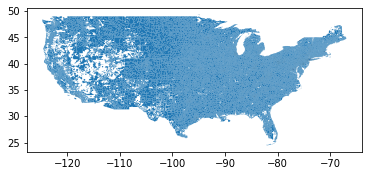

In [21]:
zctas = (
    gpd.read_file(
        "../data/census/tl_2018_us_zcta510",
    )    
    # Limit to "Lower 48" + DC
    .cx[-124.848974:-66.885444, 24.396308:49.384358]
)

zctas.plot()
pass

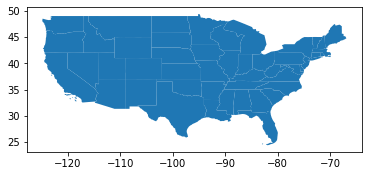

In [22]:
states = (
    gpd
    .read_file(
        "../data/census/tl_2018_us_state/"
    )
    # Limit to "Lower 48" + DC
    .cx[-124.848974:-66.885444, 24.396308:49.384358]
)

states.plot()
pass

In [23]:
def map_df(df, color, basemap = states):
    
    fig, ax = plt.subplots(figsize = (16, 9))
    
    if color[-1] == "s":
        options = {
            "cmap": color,
            "color": None,
            "column": "contributors",
            "ax": ax
        }
    else:
        options = {
            "cmap": None,
            "color": color,
            "column": "contributors",
            "ax": ax
        }

    ax = (
        basemap
        .plot(
            color = "gray",
            edgecolor = "white",
            linewidth = 0.5,
            ax = ax
        )
    )

    ax = (
        zctas
        .merge(
            df,
            left_on = "ZCTA5CE10",
            right_on = "contributor_zip_code"
        )
        .plot(
            **options
        )
    )

    ax.axis("off");
    
    
# Maps contributors and zipcodes for a candidate name
def map_donors(name, cutoff = 0, color = "Reds"):
    
    df = (
        zip_totals
        .loc[
            lambda x: x['candidate_name'] == name
        ]
        .loc[
            lambda x: x['contributors'] > cutoff
        ]
    )
    
    map_df(df, color)
    
def donors_percapita(name, cutoff = 0, color = "Reds"):
    
    df = (
        zip_totals
        .loc[
            lambda x: x['candidate_name'] == name
        ]
        .loc[
            lambda x: x["zip_population"] >= 1000
        ]
        .loc[
            lambda x: x['donors_per_1000_people'] > cutoff
        ]
    )
    
    map_df(df, color)

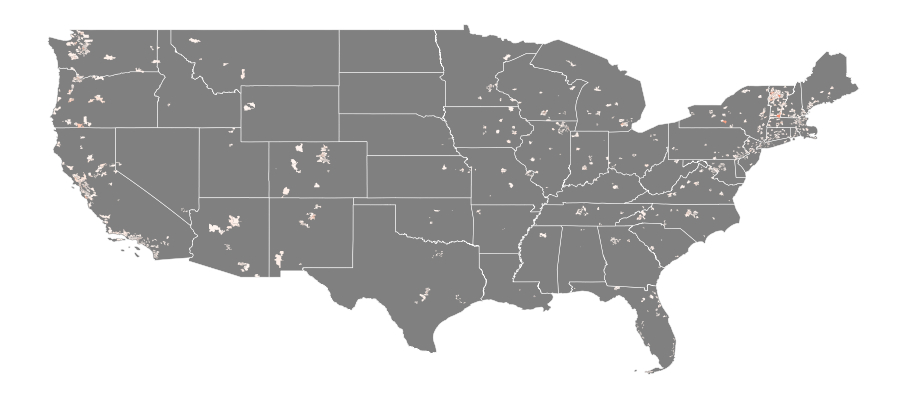

In [24]:
map_donors("BERNIE 2016", 10, "Reds")

In [25]:
# Maps contributors and zipcodes for a candidate name
def map_ca(name, cutoff = 0, color = "Reds"):
    
    # filter for name, cutoff and state
    df = (
        zip_totals
        .loc[
            lambda x: x['candidate_name'] == name
        ]
        .loc[
            lambda x: x['contributors'] > cutoff
        ]
        .loc[
            lambda x: x['state'] == "California" 
        ]
    )
    
    # define basemap
    ca = (
        states
        .loc[
            lambda x: x['NAME'] == "California"
        ]
    )
    
    map_df(df, color, ca)
    
# Maps contributors and zipcodes for a candidate name
def map_ca_percapita(name, cutoff = 0, color = "Reds"):
    
    # filter for name, cutoff and state
    df = (
        zip_totals
        .loc[
            lambda x: x['state'] == "California" 
        ]
        .loc[
            lambda x: x['candidate_name'] == name
        ]
        .loc[
            lambda x: x["zip_population"] >= 1000
        ]
        .loc[
            lambda x: x['donors_per_1000_people'] > cutoff
        ]

    )
    
    # define basemap
    ca = (
        states
        .loc[
            lambda x: x['NAME'] == "California"
        ]
    )
    
    map_df(df, color, ca)
    

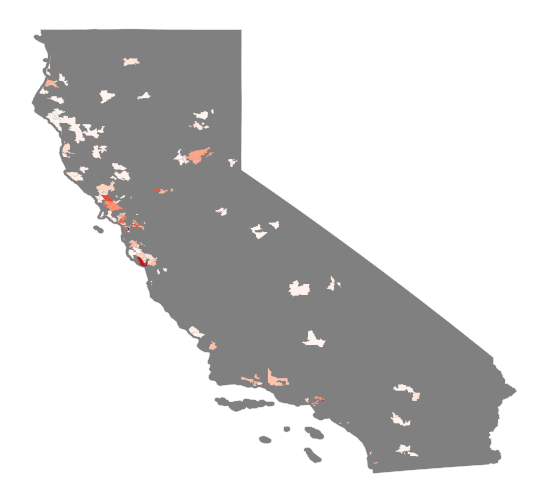

In [26]:
map_ca_percapita("BERNIE 2016", 1)

In [27]:
end = datetime.datetime.now()

d = (end - start)

f"The notebook ran for {round(d.total_seconds() / 60, 2) } minutes"

'The notebook ran for 0.82 minutes'

---

---

---